# Delivering letters in a city

The postman of a given city should get the letters at a given station and deliver them to the recipients.

In order to ensure maximum efficiency and productivity, the postman will need to learn the shortest path between the item packaging area and all other locations within the city where they are allowed to travel. In order to accomplish this task, we will use what you have learned in the Q-learning sessions!

In [ ]:
import numpy as np

## The Environment

The first step of our Q-learning is to define the environment through which the postman will navigate.

As seen in the lecture, the environment consists of **states**, **actions**, and **rewards**. States and actions are inputs for the Q-learning AI agent, while the possible actions are the AI agent's outputs.

#### States
The states in our environment are all of the possible locations within the city. Some of these locations are the city boundaries (**black squares**), while other locations are aisles that the postman can use to travel throughout the city (**white squares**). The **green square** indicates the item packaging and shipping area. The black and green squares are terminal states.

The AI agent's goal is to learn the shortest path between the item packaging area and all of the other locations in the city where the postman is allowed to travel.

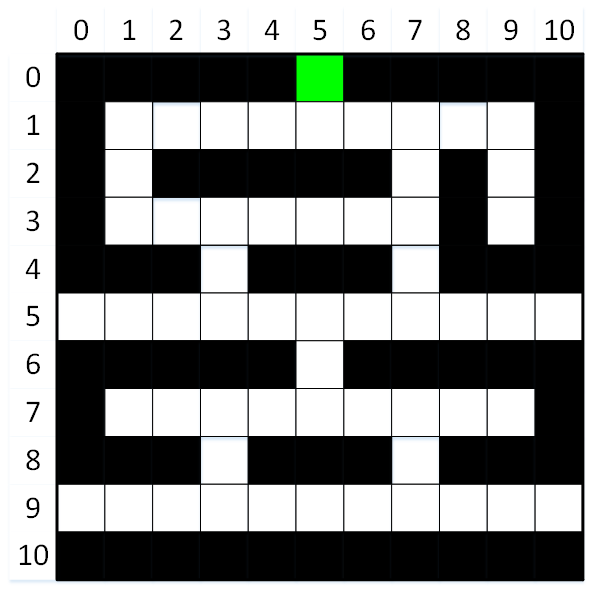


As shown in the image above, there are 121 possible states (locations) within the city. These states are arranged in a grid containing 11 rows and 11 columns. Each location can hence be identified by its row and column index.

First, let us define the environment boundaries and define a 3D numpy array to hold the current Q-values for each state and action pair: Q(s,a).

In [15]:
environment_rows = 11
environment_columns = 11

q_values = np.zeros((environment_rows, environment_columns, 4))

#### Actions

The actions that are available to the AI agent are to move the postman in one of four directions:

* Up
* Right
* Down
* Left

Obviously, the AI agent must learn to avoid driving into the city boundaries!

In [16]:
actions = ['up', 'right', 'down', 'left']

#### Rewards

To help the AI agent learn, each state (location) in the city is assigned a reward value.

The agent may begin at any white square, but its goal is always the same: ***to maximize its total rewards***.

Negative rewards (i.e., **punishments**) are used for all states except the goal, which encourages the AI to identify the *shortest path* to the goal by *minimizing its punishments*.

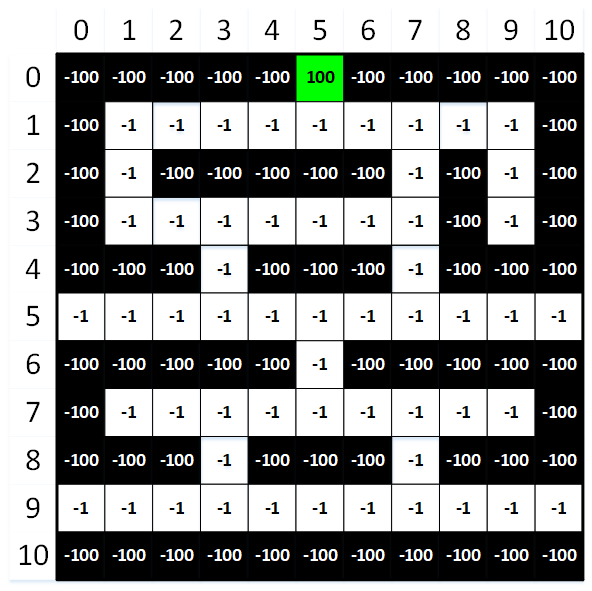

To maximize its cumulative rewards (by minimizing its cumulative punishments), the AI agent will need to find the shortest paths between the item packaging area (green square) and all of the other locations in the city where the postman is allowed to travel (white squares). The agent will also need to learn to avoid crashing into any of the city boundaries (black squares)!

Let us create the map of the city in respect to rewards and punishment points.

In [17]:
# Reward points
rewards = np.full((environment_rows, environment_columns), -100.)
rewards[0, 5] = 100. 

# White spaces
aisles = {}
aisles[1] = [i for i in range(1, 10)]
aisles[2] = [1, 7, 9]
aisles[3] = [i for i in range(1, 8)]
aisles[3].append(9)
aisles[4] = [3, 7]
aisles[5] = [i for i in range(11)]
aisles[6] = [5]
aisles[7] = [i for i in range(1, 10)]
aisles[8] = [3, 7]
aisles[9] = [i for i in range(11)]

for row_index in range(1, 10):
    for column_index in aisles[row_index]:
        rewards[row_index, column_index] = -1.

This is what the map looks like:

In [18]:
for row in rewards:
    print(row)

[-100. -100. -100. -100. -100.  100. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100.   -1. -100. -100. -100. -100. -100.   -1. -100.   -1. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.   -1. -100.]
[-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-100. -100. -100. -100. -100.   -1. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]


## Train the Model

The learning process will follow these steps:

1. Choose a random, non-terminal state (white square) for the agent to begin this new episode.
2. Choose an action (move *up*, *right*, *down*, or *left*) for the current state. Actions will be chosen using an *epsilon greedy algorithm*. This algorithm will usually choose the most promising action for the AI agent, but it will occasionally choose a less promising option in order to encourage the agent to explore the environment.
3. Perform the chosen action, and transition to the next state (i.e., move to the next location).
4. Receive the reward for moving to the new state, and calculate the temporal difference.
5. Update the Q-value for the previous state and action pair.
6. If the new (current) state is a terminal state, go to #1. Else, go to #2.

This entire process will be repeated across 1000 episodes. This will provide the AI agent sufficient opportunity to learn the shortest paths between the item packaging area and all other locations in the city where the postman is allowed to travel, while simultaneously avoiding crashing into the city boundaries.

#### Define Helper Functions

We will define a few helper functions to train our model.

In [19]:
def is_terminal_state(current_row_index, current_column_index):
    """
    Function to determine if the specified location is a terminal state
    """

    if rewards[current_row_index, current_column_index] == -1.:
        return False
    else:
        return True

def get_starting_location():
    """
    Function to choose a random non-terminal starting location.
    """

    current_row_index = np.random.randint(environment_rows)

    current_column_index = np.random.randint(environment_columns)

    while is_terminal_state(current_row_index, current_column_index):
        current_row_index = np.random.randint(environment_rows)
        current_column_index = np.random.randint(environment_columns)

    return current_row_index, current_column_index

def get_next_action(current_row_index, current_column_index, epsilon):
    """
    Function to choose the next action, according to the epsilon value.
    """

    if np.random.random() < epsilon:
        return np.argmax(q_values[current_row_index, current_column_index])
    else:
        return np.random.randint(4)

def get_next_location(current_row_index, current_column_index, action_index):
    """
    Function to get the next location based on the chosen action.
    """

    new_row_index = current_row_index
    new_column_index = current_column_index
    
    if actions[action_index] == 'up' and current_row_index > 0:
        new_row_index -= 1
    elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
        new_column_index += 1
    elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
        new_row_index += 1
    elif actions[action_index] == 'left' and current_column_index > 0:
        new_column_index -= 1
    return new_row_index, new_column_index

def get_shortest_path(start_row_index, start_column_index):
    """
    Function that will get the shortest path between any location within the city 
    that the postman is allowed to travel and the item packaging location.
    """

    if is_terminal_state(start_row_index, start_column_index):
        return []
    else: 
        current_row_index, current_column_index = start_row_index, start_column_index
        shortest_path = []
        shortest_path.append([current_row_index, current_column_index])

        while not is_terminal_state(current_row_index, current_column_index):
            action_index = get_next_action(current_row_index, current_column_index, 1.)
            current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
            shortest_path.append([current_row_index, current_column_index])
            
    return shortest_path

#### Train the AI Agent using Q-Learning

In [20]:
epsilon = 0.9 # the percentage of time when we should take the best action (instead of a random action)
discount_factor = 0.9 # discount factor for future rewards
learning_rate = 0.9 # the rate at which the AI agent should learn
n_training_episodes = 1000

for episode in range(n_training_episodes):

    row_index, column_index = get_starting_location()

    while not is_terminal_state(row_index, column_index):

        action_index = get_next_action(row_index, column_index, epsilon)

        old_row_index, old_column_index = row_index, column_index
        row_index, column_index = get_next_location(row_index, column_index, action_index)

        reward = rewards[row_index, column_index]
        old_q_value = q_values[old_row_index, old_column_index, action_index]
        temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

        new_q_value = old_q_value + (learning_rate * temporal_difference)
        q_values[old_row_index, old_column_index, action_index] = new_q_value

print('Training complete!')

Training complete!


Next, find a few samples of shortest paths.

In [21]:
print(get_shortest_path(3, 9)) #starting at row 3, column 9
print(get_shortest_path(5, 0)) #starting at row 5, column 0
print(get_shortest_path(9, 5)) #starting at row 9, column 5

[[3, 9], [2, 9], [1, 9], [1, 8], [1, 7], [1, 6], [1, 5], [0, 5]]
[[5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [4, 7], [3, 7], [2, 7], [1, 7], [1, 6], [1, 5], [0, 5]]
[[9, 5], [9, 6], [9, 7], [8, 7], [7, 7], [7, 6], [7, 5], [6, 5], [5, 5], [5, 6], [5, 7], [4, 7], [3, 7], [2, 7], [1, 7], [1, 6], [1, 5], [0, 5]]


#### Finally...
It's great that our postman can automatically take the shortest path from any 'legal' location in the city to the item packaging area. **But what about the opposite scenario?**

Put differently, our postman can currently deliver an item from anywhere in the city ***to*** the packaging area, but after it delivers the item, it will need to travel ***from*** the packaging area to another location in the city to pick up the next item!

Don't worry -- this problem is easily solved simply by ***reversing the order of the shortest path***.

Run the code cell below to see an example:

In [22]:
path = get_shortest_path(5, 2) #go to row 5, column 2
path.reverse()
print(path)

[[0, 5], [1, 5], [1, 6], [1, 7], [2, 7], [3, 7], [4, 7], [5, 7], [5, 6], [5, 5], [5, 4], [5, 3], [5, 2]]
